In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn import metrics
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression, Ridge
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import plotly
import chart_studio.plotly as py
import cufflinks as cf

sns.set()
pd.options.plotting.backend = 'plotly'

**Funcion para realizar la prediccion**

In [2]:
def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
          corr['x'], corr['y'],
          color=corr['value'], color_range=[-1, 1],
          palette=sns.diverging_palette(20, 220, n=256),
          size=corr['value'].abs(), size_range=[0,1],
          marker=marker,
          x_order=data.columns,
          y_order=data.columns[::-1],
          size_scale=size_scale
      )

In [3]:

def calculos(datos, columna):
    x = datos.drop( columna, axis=1)
    y = datos[columna]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size =.2)
    linreg = LinearRegression()
    linreg.fit(x_train, y_train)
    coeff_df = pd.DataFrame(linreg.coef_, x.columns, columns=['Coefficient'])
    
    train_score = linreg.score(x_train,y_train)
    test_score = linreg.score(x_test,y_test)
    predicted = linreg.predict(x_test)
    
    rr = Ridge()
    rr.fit(x_train,y_train)
    rr100 = Ridge(alpha=100)
    rr100.fit(x_train,y_train)
    ridge_train_score = rr.score(x_train,y_train)
    ridge_test_score = rr.score(x_test,y_test)
    predicted_ridge = rr.predict(x_test)
    ridge_train_score100 = rr100.score(x_train,y_train)
    ridge_test_score100 = rr100.score(x_test,y_test)
    predicted_ridge100 = rr100.predict(x_test)
    def grafica1():
        visualizer = ResidualsPlot(linreg, hist=False)
        visualizer.fit(x_test,y_test)
    def grafica2():
        fig = plt.figure(facecolor='w',figsize=(12, 12))
        plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=9,\
             color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7)
        plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=10,\
             color='blue',label=r'Ridge; $\alpha = 100$')
        plt.plot(linreg.coef_,alpha=0.4,linestyle='none',marker='o',markersize=14,\
             color='green',label='Linear Regression')
        plt.xlabel('Coefficient Index',fontsize=16)
        plt.ylabel('Coefficient Magnitude',fontsize=16)
        plt.legend(fontsize=13,loc=4)
        plt.show()
    df_predict = pd.DataFrame({'Actual':y_test, 'Predicted':predicted, 'PredictedRidge':predicted_ridge, 'PredictedRidge100':predicted_ridge100 })
    print (metrics.mean_absolute_error(y_test,predicted), 'Media de error')
    print(train_score, 'Train Score')
    print(test_score, 'Test Score')
    print(ridge_train_score, 'Ridge Train Score')
    print(ridge_test_score, 'Ridge Test Score')
    print(ridge_train_score100, 'Ridge100 Train Score')
    print(ridge_test_score100, 'Ridge100 Test Score')
    
    return grafica1(), grafica2(), print(coeff_df), print(df_predict.head(10))




In [4]:
data = pd.read_csv('./train.csv')

In [5]:
data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [7]:
null_cols = data.isnull().sum()
null_cols[null_cols > 0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [8]:
data[['PoolQC', 'FireplaceQu','GarageType', 'GarageFinish', 'GarageCond', 'GarageQual','Alley', 'BsmtQual', 'BsmtCond']]=data[['PoolQC', 
                                            'FireplaceQu','GarageType', 'GarageFinish', 'GarageCond', 'GarageQual',
                                           'Alley', 'BsmtQual', 'BsmtCond']].fillna('NA')             

In [9]:
null_cols = data.isnull().sum()
null_cols[null_cols > 10]

LotFrontage      259
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
GarageYrBlt       81
Fence           1179
MiscFeature     1406
dtype: int64

In [10]:
drop_cols = list(null_cols[null_cols > 10].index)
data = data.drop(drop_cols, axis=1)


In [11]:
data = data.dropna(axis=0)

In [12]:
null_cols = data.isnull().sum()
null_cols[null_cols > 0]

Series([], dtype: int64)

In [13]:
data['foundatincat'] = pd.factorize(data.Foundation)[0]
data['bldgtypecat']= pd.factorize(data.BldgType)[0]
data['housestylecat']= pd.factorize(data.HouseStyle)[0]
data['externqualcat']= pd.factorize(data.ExterQual)[0]
data['kitchenquacat']= pd.factorize(data.KitchenQual)[0]
data['gargetypecat']= pd.factorize(data.GarageType)[0]
data['SalePrice']=data.SalePrice.div(100000)

In [14]:
corr = pd.DataFrame(data.corr())
corr['SalePrice'].nlargest(11)

SalePrice       1.000000
OverallQual     0.790085
GrLivArea       0.710073
GarageCars      0.639749
GarageArea      0.622484
TotalBsmtSF     0.613299
1stFlrSF        0.606969
FullBath        0.562710
TotRmsAbvGrd    0.536366
YearBuilt       0.523274
YearRemodAdd    0.507488
Name: SalePrice, dtype: float64

In [15]:
corr['SalePrice'].nsmallest(10)

foundatincat    -0.429450
externqualcat   -0.271452
gargetypecat    -0.255267
housestylecat   -0.188758
KitchenAbvGr    -0.137447
EnclosedPorch   -0.128826
kitchenquacat   -0.119119
bldgtypecat     -0.112324
MSSubClass      -0.082760
OverallCond     -0.076361
Name: SalePrice, dtype: float64

Modelo usando los 5 rubros que tienen mayor correlacion posiiva y los 5 que tiene mayor correlacion negativa

In [16]:
data1= data[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', '1stFlrSF', 'KitchenAbvGr',
            'EnclosedPorch', 'MSSubClass', 'OverallCond', 'YrSold']]


In [17]:
corrplot(data1.corr())

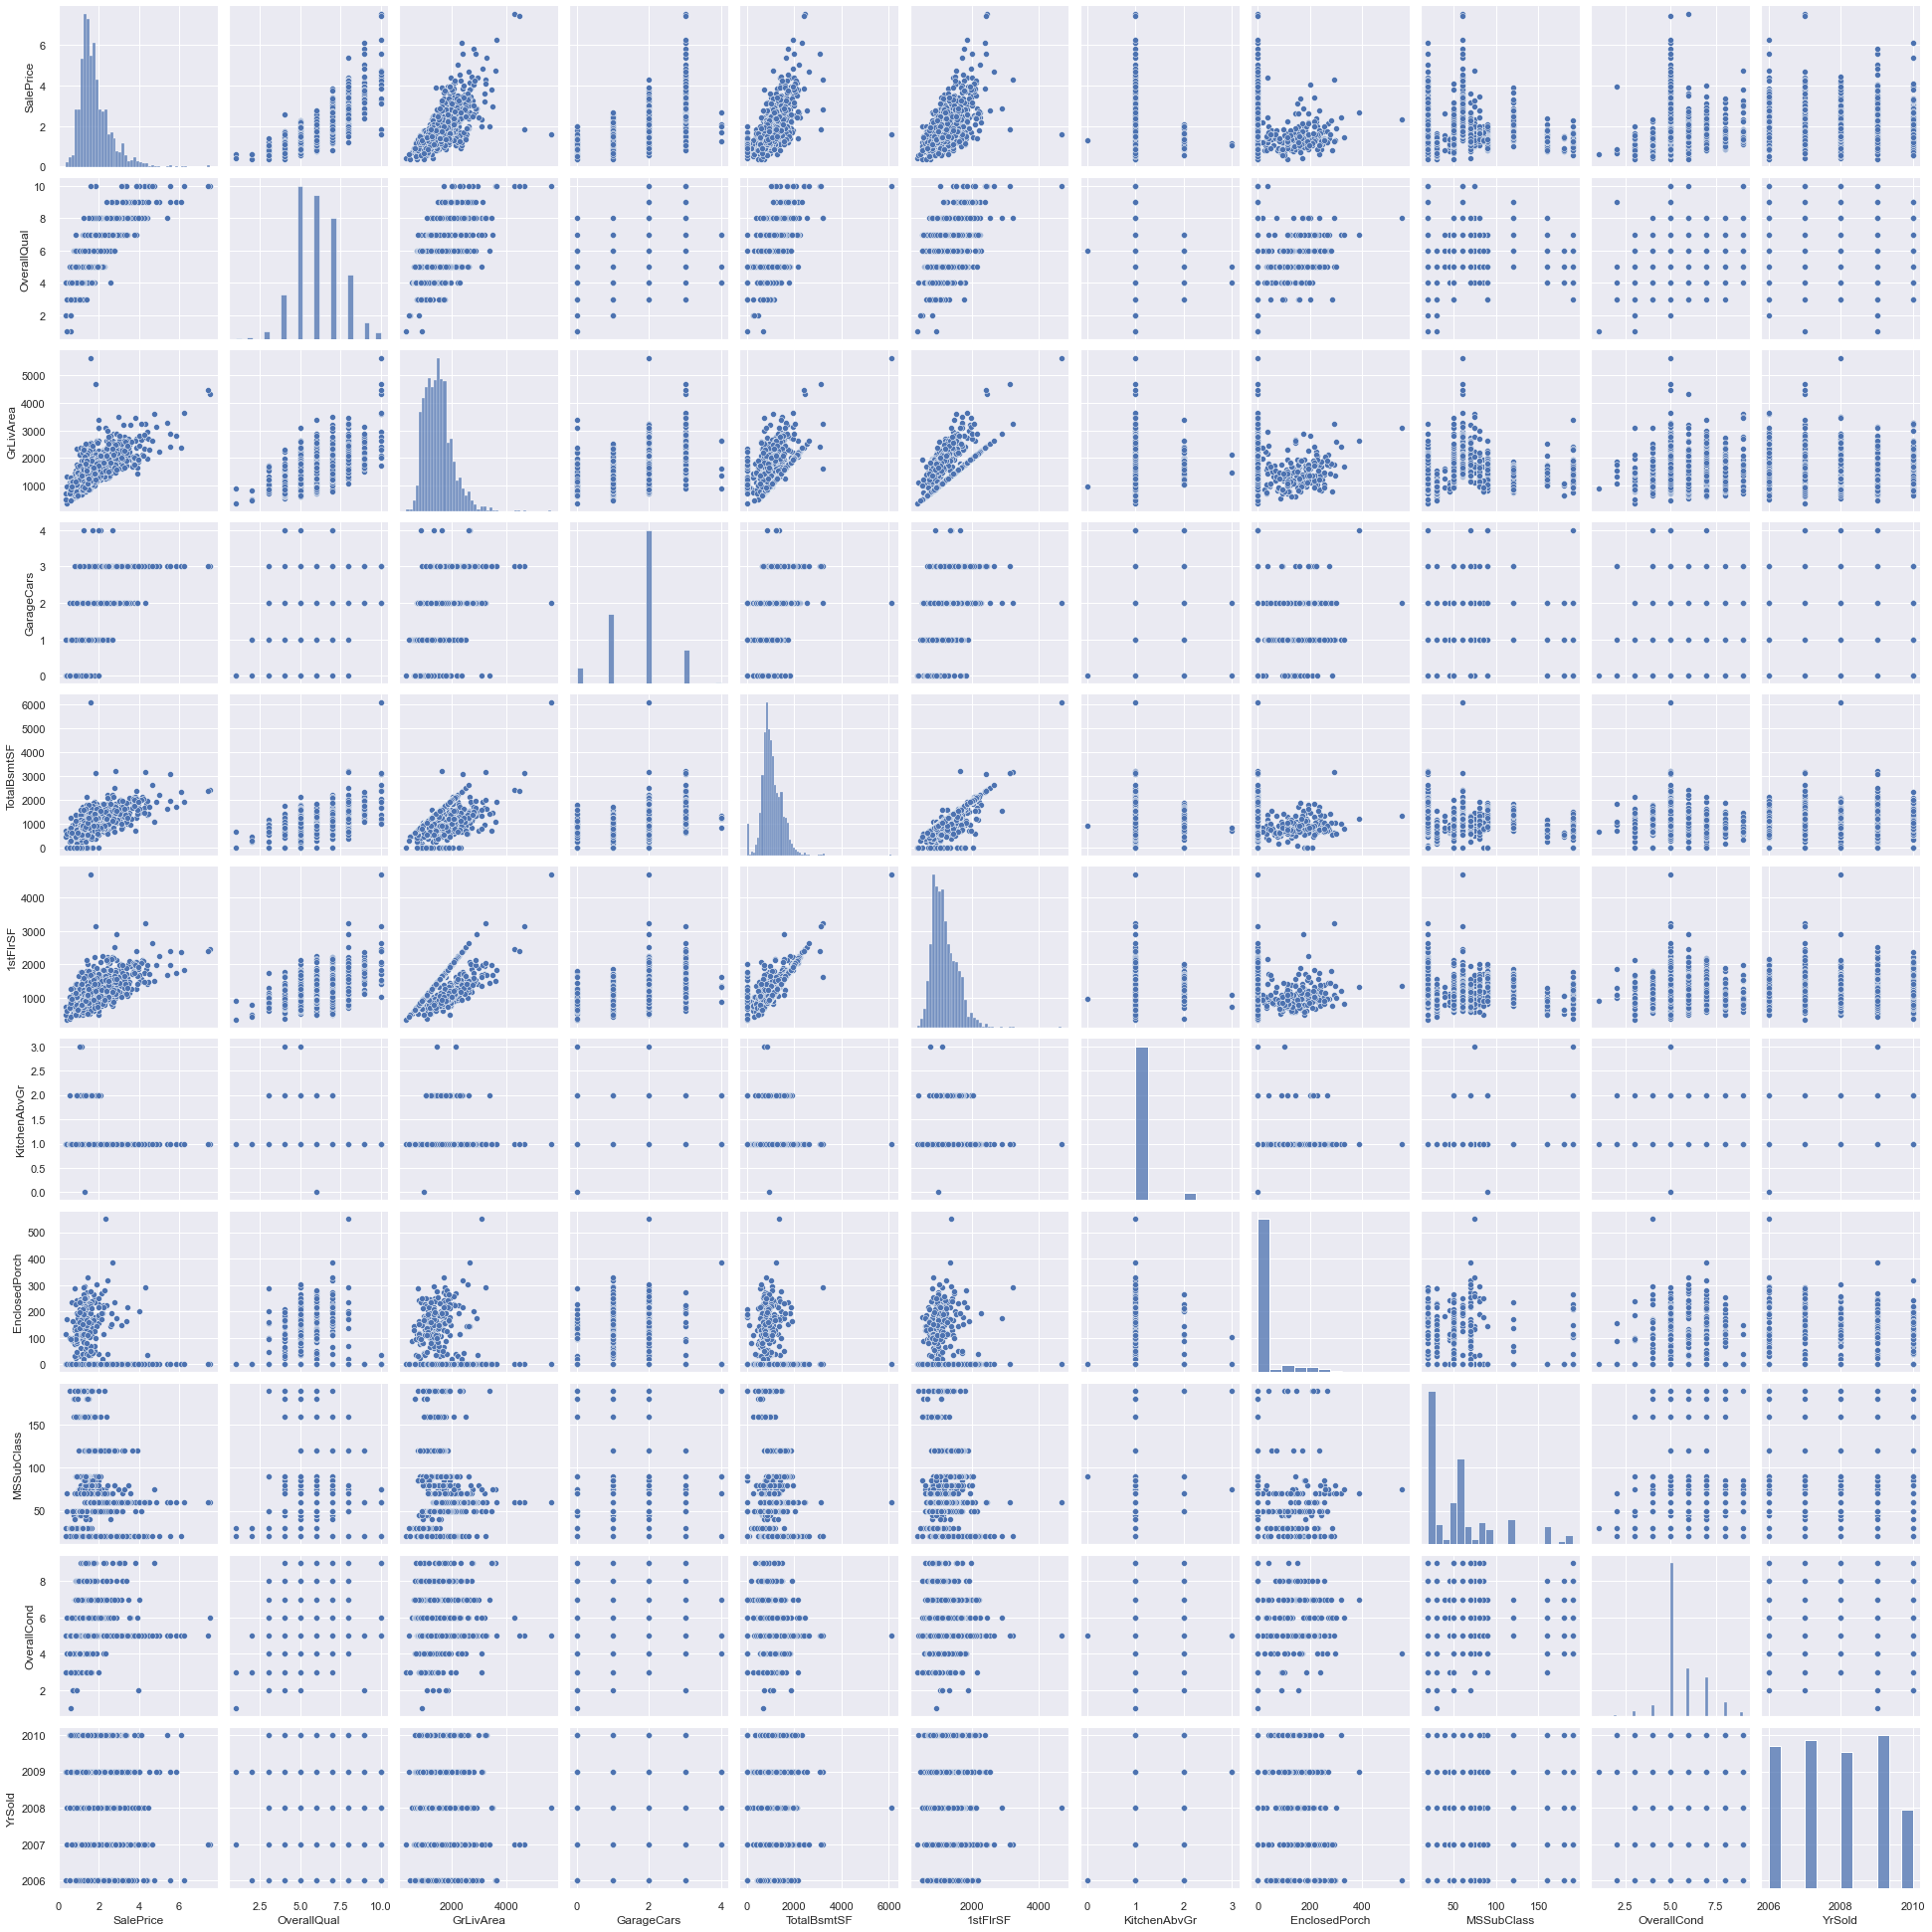

In [18]:
ax= sns.pairplot(data1)

0.26327493037376587 Media de error
0.7686855031684653 Train Score
0.7828086356792178 Test Score
0.7686838789018466 Ridge Train Score
0.7828969205406421 Ridge Test Score
0.7661638656635387 Ridge100 Train Score
0.7875200181962849 Ridge100 Test Score


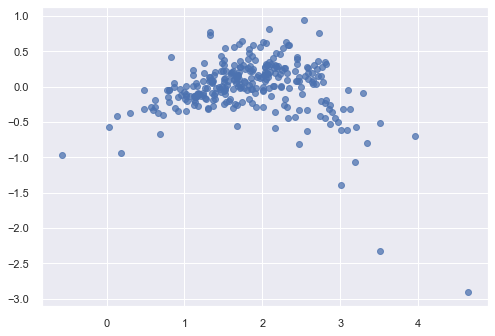

               Coefficient
OverallQual       0.235093
GrLivArea         0.000444
GarageCars        0.197934
TotalBsmtSF       0.000170
1stFlrSF          0.000132
KitchenAbvGr     -0.231957
EnclosedPorch    -0.000461
MSSubClass       -0.001031
OverallCond       0.028393
YrSold            0.003551
       Actual  Predicted  PredictedRidge  PredictedRidge100
1104  1.06000   1.253850        1.252655           1.216825
290   2.33230   2.467997        2.468211           2.465222
1355  1.70000   2.173297        2.172563           2.137798
760   1.27500   1.347247        1.347856           1.364911
917   1.35000   1.133079        1.133013           1.157784
445   1.27500   2.088941        2.088564           2.083100
212   2.52678   2.163965        2.163924           2.157675
416   1.49500   1.701401        1.701373           1.688156
1316  2.95493   2.754791        2.754646           2.722881
423   3.15000   3.106552        3.106120           3.084410


(None, None, None, None)

In [20]:
calculos(data1,'SalePrice')

Modelo con los 10 rubros con mayor correlacion

In [21]:
data2= data[['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF',
            'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']]



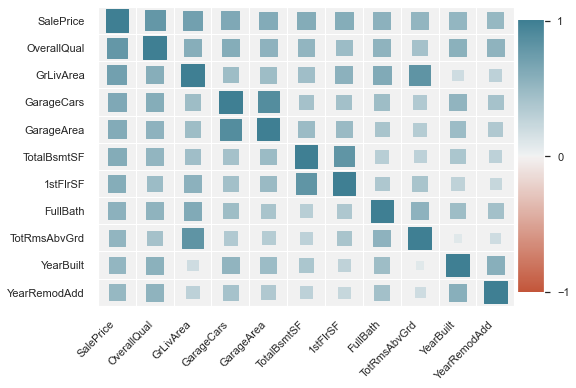

In [22]:
corrplot(data2.corr())

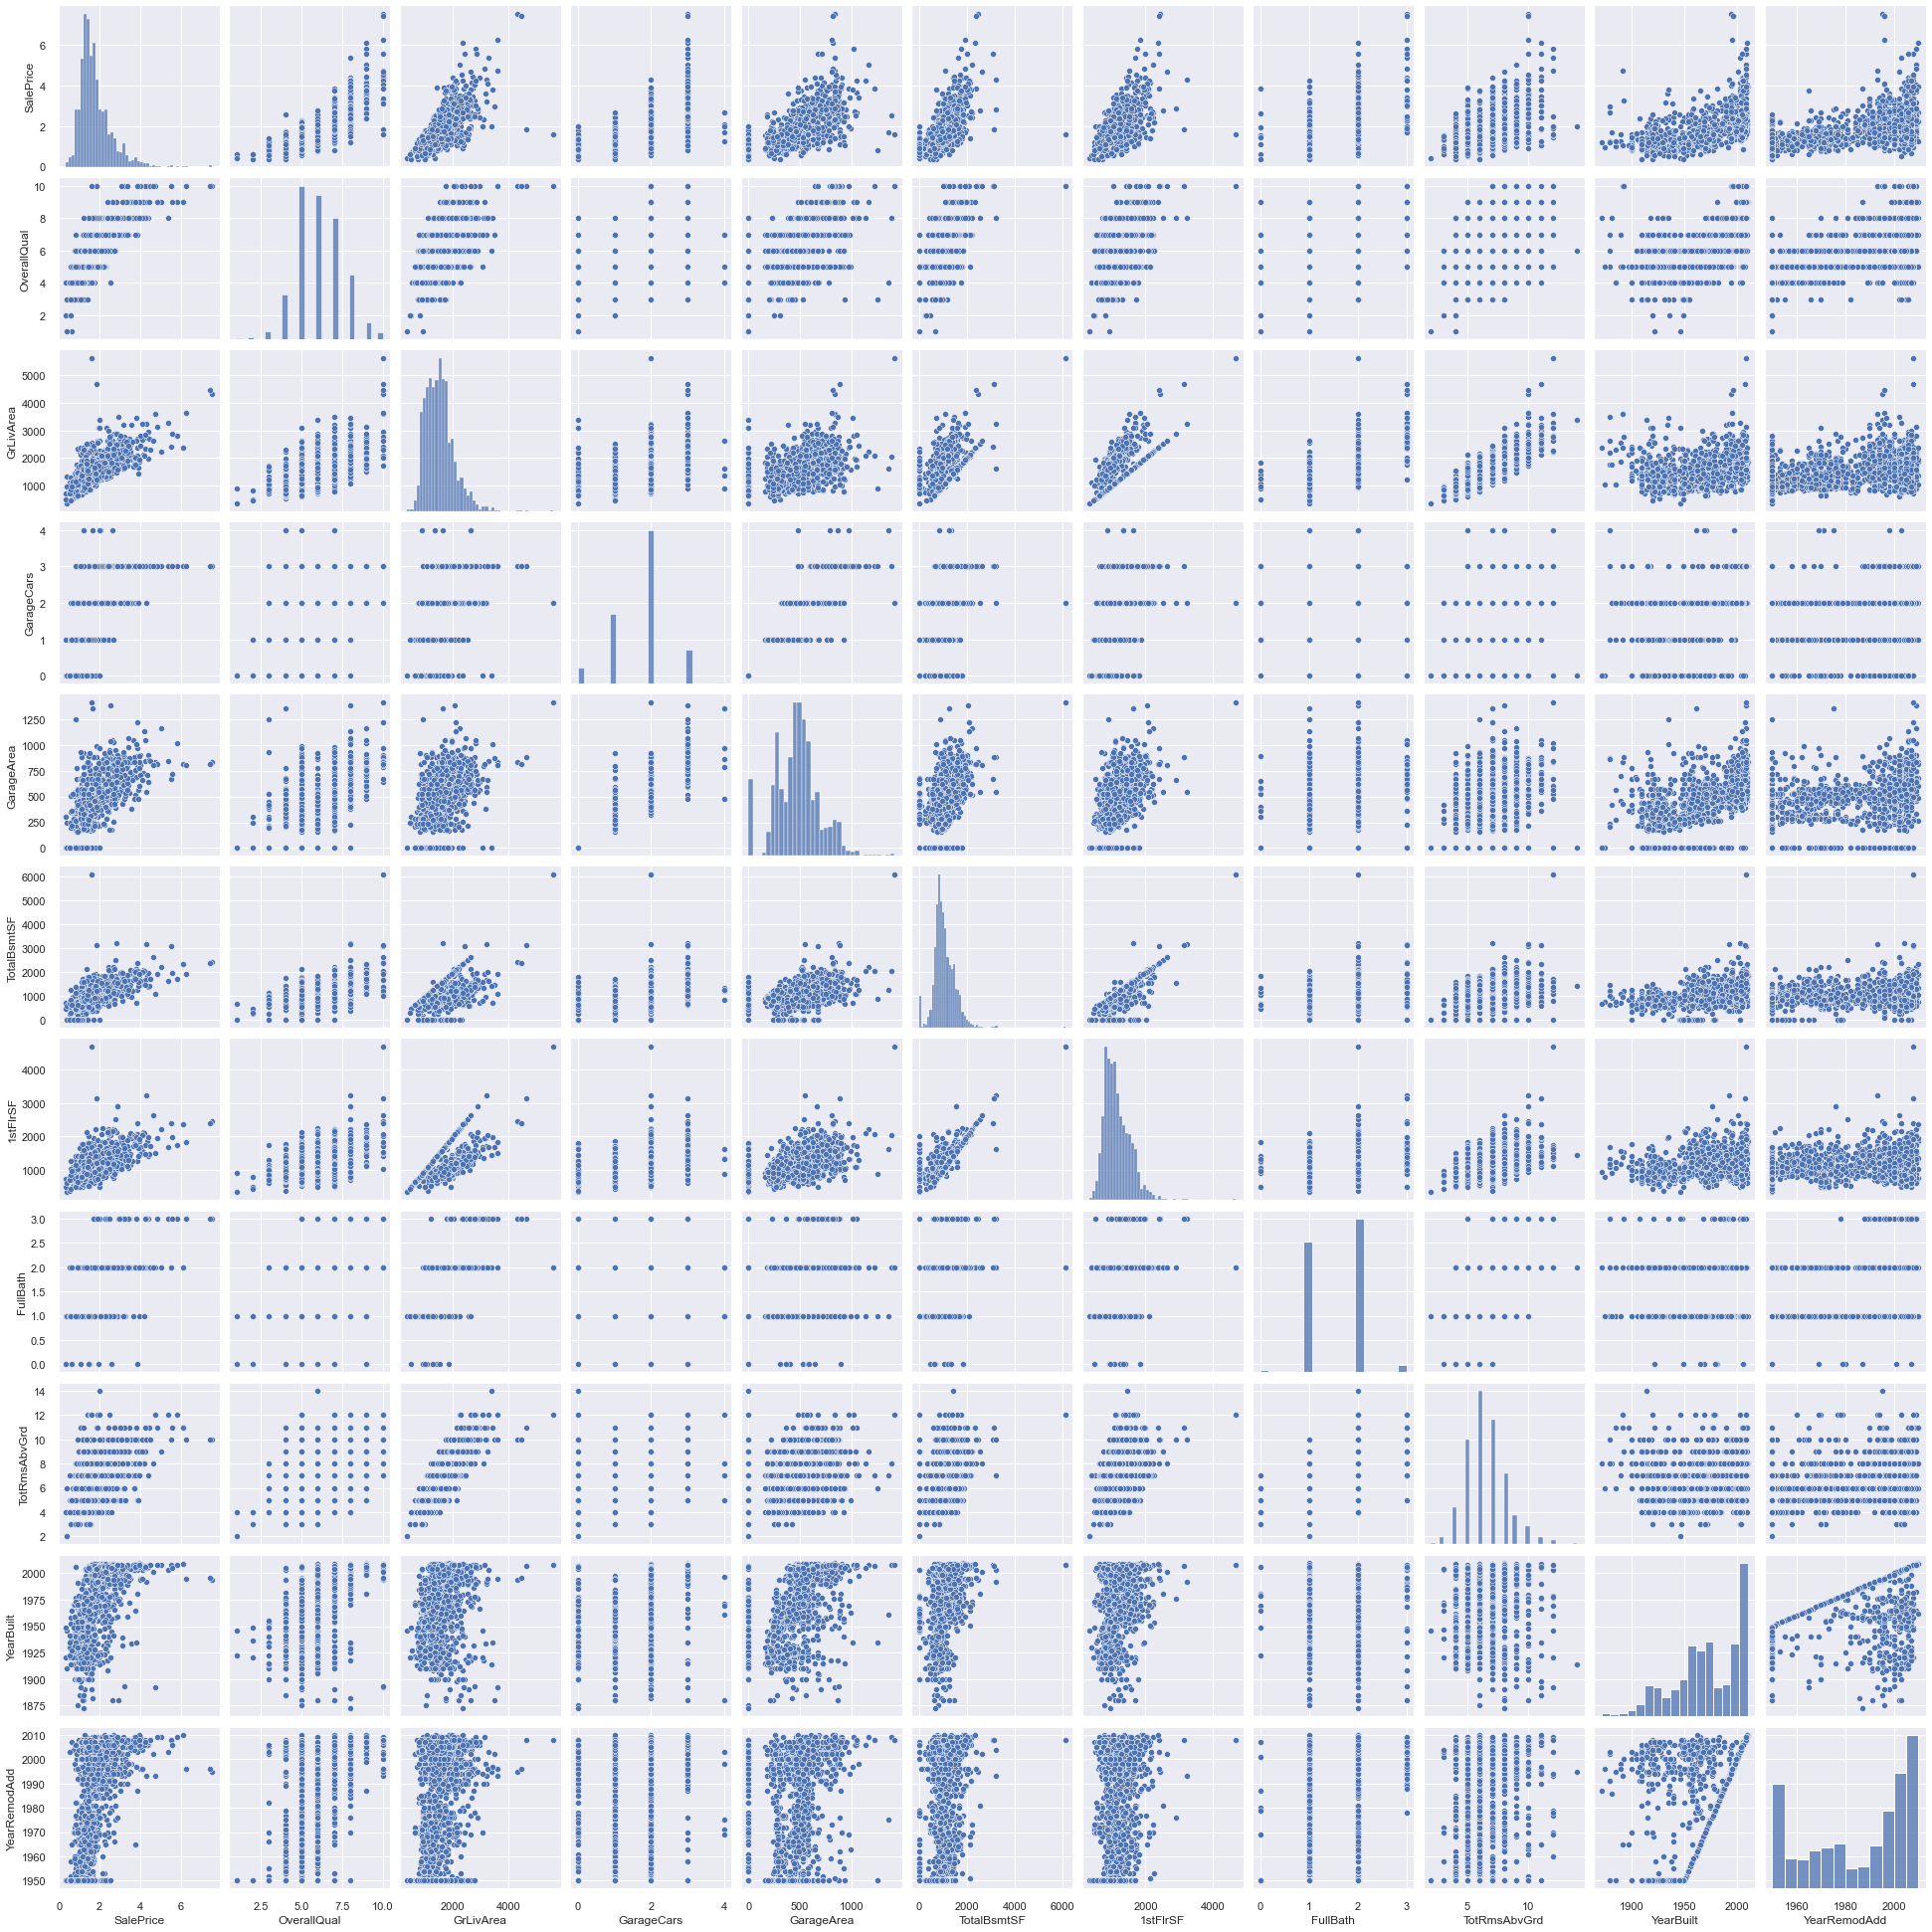

In [23]:
ax= sns.pairplot(data2)

0.24154032177209436 Media de error
0.7719165366948607 Train Score
0.777404703039883 Test Score
0.7719163027613791 Ridge Train Score
0.7774514906710596 Ridge Test Score
0.770832497347405 Ridge100 Train Score
0.7800445933726299 Ridge100 Test Score


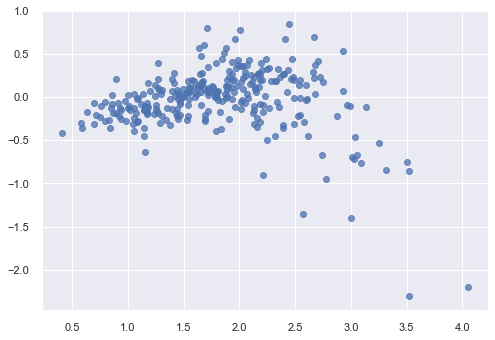

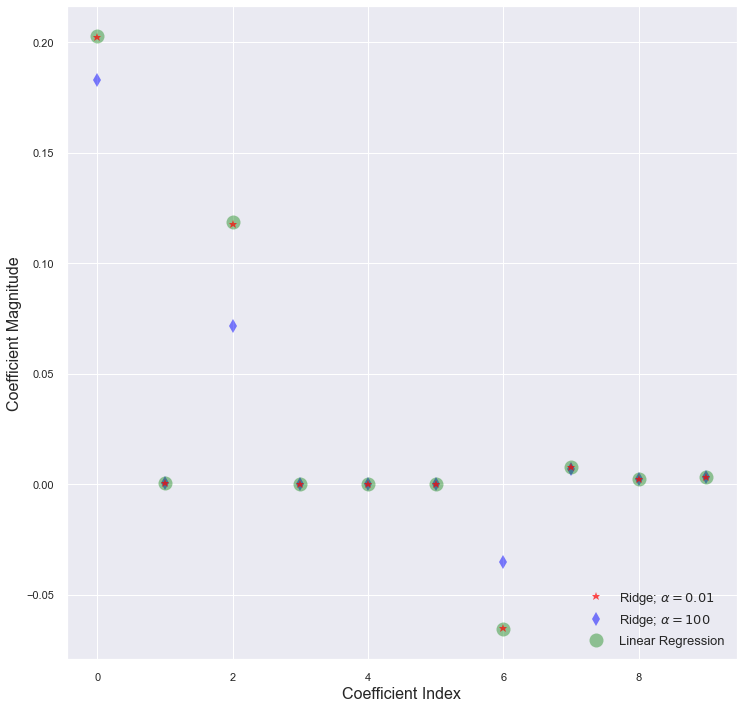

              Coefficient
OverallQual      0.202671
GrLivArea        0.000478
GarageCars       0.118585
GarageArea       0.000080
TotalBsmtSF      0.000165
1stFlrSF         0.000160
FullBath        -0.065577
TotRmsAbvGrd     0.007761
YearBuilt        0.002332
YearRemodAdd     0.003169
       Actual  Predicted  PredictedRidge  PredictedRidge100
1073  1.59500   1.653292        1.652734           1.620881
791   1.46800   1.588177        1.587866           1.568028
746   2.36000   2.426826        2.426978           2.439182
1458  1.42125   1.264059        1.264056           1.267393
203   1.49000   1.550656        1.550188           1.524815
670   1.73500   1.795718        1.796051           1.820395
594   1.10000   1.135277        1.135359           1.142222
389   4.26000   3.505127        3.504596           3.459498
779   1.35000   1.537178        1.536795           1.512578
993   1.73900   1.808424        1.808830           1.838113


(None, None, None, None)

In [24]:
calculos(data2,'SalePrice')

In [25]:
data.to_excel('train_limpio.xlsx', index=False)

In [26]:
data['timeremodelation'] = data['YearRemodAdd']-data['YearBuilt']

In [27]:
data['antiguedadventa']= data['YrSold']-data['YearBuilt']

In [28]:
condition1= [data['timeremodelation']==0]
choices1= [0]
data['remodelation'] = np.select(condition1,choices1, default= 1)
data['venta']= 1

In [29]:
def survival(data, group_field, time_field, event_field):
    """Documentacion de la funcion."""
    model = KaplanMeierFitter()
    results = []
    con_exp = []
    
    for i in data[group_field].unique():
        group = data[data[group_field] == i]
        T = group[time_field]
        E = group[event_field]
        con_exp.append([T, E])
        model.fit(T, E, label=str(i))
        results.append(model.survival_function_)
    
    survival = pd.concat(results, axis=1)
    front_fill = survival.fillna(method='ffill')
    back_fill = survival.fillna(method='bfill')
    smoothed = (front_fill + back_fill) / 2
    log_result  = logrank_test(con_exp[0][0], con_exp[1][0], 
                               event_observed_A=con_exp[0][1], 
                               event_observed_B=con_exp[1][1])
    return smoothed, log_result

In [30]:
rates, logrank= survival(data, 'Foundation', 'antiguedadventa', 'remodelation')

rates.plot(kind='line',title = 'Indice de remodelacion por antiguedad y materiales de construccion')



Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood

In [31]:
rates, logrank= survival(data, 'BldgType', 'antiguedadventa', 'remodelation')

rates.plot(kind='line',title = 'Indice de remodelacion por antiguedad y tipo de edificio')


BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit

In [32]:
rates, logrank= survival(data, 'OverallQual', 'antiguedadventa', 'venta')

rates.plot(kind='line',title = 'Indice de venta por antiguedad y calidad de la vivienda')


OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

In [33]:
rates, logrank= survival(data, 'GarageCars', 'antiguedadventa', 'venta')
rates.plot(kind='line',title = 'Indice de venta por antiguedad y capicidad del garage')

In [34]:
rates, logrank= survival(data, 'Functional', 'antiguedadventa', 'venta')
rates.plot(kind='line',title = 'Indice de venta por antiguedad y funcionalidad de la vivienda')

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only